# PCA 实战

## 01 梯度上升法实现PCA

在使用最大投影方差求解PCA的时候，得到了：

$$ Var(X_{project}) = \cfrac{1}{m} \sum_{i=1}^m \bigg( \sum_{j=1}^n X_j^{(i)} w_j \bigg)^2 $$

目标是求$w$使得方差最大化，就转换成了求目标函数的最优化问题，可以用梯度上升法进行求解。
![](https://github.com/pchen12567/picture_store/blob/master/Interview/PCA_08.png?raw=true)

梯度上升法的思想和梯度下降法的思路完全一样，只是前者求极大值，后者求极小值。

### 导入相关包

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 创建具有线性相关的数据：

In [2]:
X = np.empty((100, 2))
X[:,0] = np.random.uniform(0., 100, size=100)
X[:,1] = 0.75 * X[:, 0] + 3. + np.random.normal(0, 10., size=100)

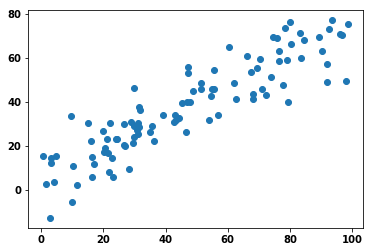

In [3]:
plt.scatter(X[:,0], X[:,1])
plt.show()

### 去中心化

In [4]:
def demean(X):
    return X - np.mean(X, axis=0)

In [5]:
X_demean = demean(X)

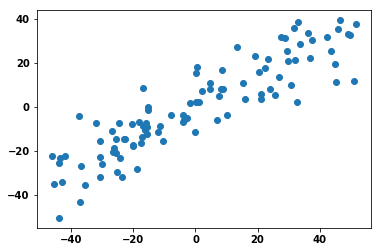

In [6]:
plt.scatter(X_demean[:,0], X_demean[:,1])
plt.show()

In [7]:
np.mean(X_demean[:, 0])

2.4513724383723458e-14

In [8]:
np.mean(X_demean[:, 1])

-3.268496584496461e-15

### 梯度上升法

In [9]:
def variance(X, w):
    return np.sum((X.dot(w)**2)) / len(X)

In [10]:
def df(X, w):
    return X.T.dot(X.dot(w)) * 2 / len(X)

In [11]:
def direction(w):
    # linalg = linear（线性）+algebra（代数），norm则表示范数，默认为二范数。
    return w / np.linalg.norm(w)

In [12]:
def gradient_ascent(X, init_w, alpha, n_iters=1e4, epsilon=1e-8):
    
    # Init w and iteration
    w = direction(init_w)
    cur_iter = 0
    
    while cur_iter < n_iters:
        gradient = df(X, w)
        last_w = w
        
        w = w + alpha * gradient
        w = direction(w)
        
        if abs(variance(X, w) - variance(X, last_w)) < epsilon:
            break
        
        cur_iter += 1
    
    return w

### Test

In [13]:
# 初始化w
# 注意：不能用0向量开始
init_w = np.random.random(X.shape[1]) 
init_w

array([0.29617413, 0.60875983])

In [14]:
# 设置学习率
alpha = 0.001

In [15]:
w = gradient_ascent(X_demean, init_w, alpha)
print(w)

[0.80790616 0.58931115]


### 画出对应的主轴

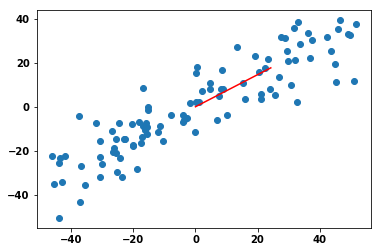

In [16]:
plt.scatter(X_demean[:,0], X_demean[:,1])
plt.plot([0, w[0]*30], [0, w[1]*30], color='r')
plt.show()

### 使用极端数据集测试

In [17]:
X2 = np.empty((100, 2))
X2[:,0] = np.random.uniform(0., 100., size=100)
X2[:,1] = 0.75 * X2[:,0] + 3.

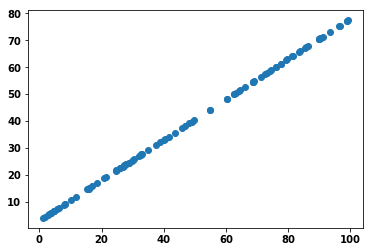

In [18]:
plt.scatter(X2[:,0], X2[:,1])
plt.show()

In [19]:
X2_demean = demean(X2)

In [20]:
w2 = gradient_ascent(X2_demean, init_w, alpha)
print(w2)

[0.7999996  0.60000054]


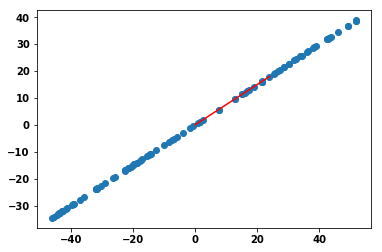

In [21]:
plt.scatter(X2_demean[:,0], X2_demean[:,1])
plt.plot([0, w2[0]*30], [0, w2[1]*30], color='r')
plt.show()

## 02 获得前n个主成分

先考虑如何计算第一个主成分：还是使用梯度上升法

In [22]:
def first_component(X, init_w, alpha, n_iters=1e4, epsilon=1e-8):
    
    w = direction(init_w)
    cur_iter = 0
    
    while cur_iter < n_iters:
        gradient = df(X, w)
        last_w = w
        
        w = w + alpha * gradient
        w = direction(w)
        
        if abs(variance(X, w) - variance(X, last_w)) < epsilon:
            break
        
        cur_iter += 1
    
    return w

In [23]:
init_w = np.random.random(X_demean.shape[1])
print(init_w)

[0.63202949 0.24537135]


In [24]:
alpha = 0.01

In [25]:
w = first_component(X_demean, init_w, alpha)
print(w)

[0.80790645 0.58931075]


In [26]:
X3 = np.empty(X_demean.shape)
for i in range(len(X_demean)):
    X3[i] = X_demean[i] - X_demean[i].dot(w) * w

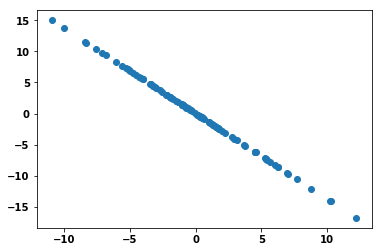

In [27]:
plt.scatter(X3[:,0], X3[:,1])
plt.show()

In [28]:
X3 = X_demean - X_demean.dot(w).reshape(-1, 1) * w

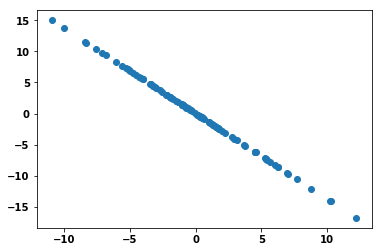

In [29]:
plt.scatter(X3[:,0], X3[:,1])
plt.show()

In [30]:
w3 = first_component(X3, init_w, alpha)
print(w3)

[ 0.58931482 -0.80790349]


In [31]:
w.dot(w3)

5.03408901170177e-06

对于只有2维特征的样本x，求解出了第一个主成分，即w=(w1,w2)，为了求解第二个主成分，这里需要将样本x在第一个主成分上的分量去除掉，这里使用的方法即空间几何的向量减法，得到的结果即下图中的绿线部分。

![](https://github.com/pchen12567/picture_store/blob/master/Interview/PCA_09.png?raw=true)

即$X^{(i)}$减去在$w$方向上的分量$(X_{pr1}^{(i)}, X_{pr2}^{(i)})$，得到新的样本数据：${X'}^{(i)} = ({X'}_{pr1}^{(i)}, {X'}_{pr2}^{(i)})$

In [32]:
def first_n_components(n, X, alpha=0.01, n_iters=1e4, epsilon=1e-8):
    X_pca = X.copy()
    X_pca = demean(X_pca)
    res = []
    
    for i in range(n):
        init_w = np.random.random(X_pca.shape[1])
        
        w = first_component(X_pca, init_w, alpha)
        
        res.append(w)
        
        X_pca = X_pca - X_pca.dot(w).reshape(-1, 1) * w
    
    return res

In [33]:
first_n_components(2, X)

[array([0.8079064 , 0.58931083]), array([ 0.58931424, -0.80790391])]

## 03 从高维数据向低维数据的映射

使用封装好的PCA

In [34]:
from PCA import PCA

In [35]:
X = np.empty((100, 2))
X[:,0] = np.random.uniform(0., 100., size=100)
X[:,1] = 0.75 * X[:,0] + 3. + np.random.normal(0, 10., size=100)

In [36]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

对应的主成分

In [37]:
pca.components_

array([[ 0.76714794,  0.64147022],
       [ 0.64147217, -0.7671463 ]])

In [38]:
pca = PCA(n_components=1)
pca.fit(X)

PCA(n_components=1)

In [39]:
X_reduction = pca.transform(X)

In [40]:
X_reduction.shape

(100, 1)

In [41]:
X_restore = pca.inverse_transform(X_reduction)

In [42]:
X_restore.shape

(100, 2)

将样本数据和经过fit_transform降维后的数据展现在同一张图上:

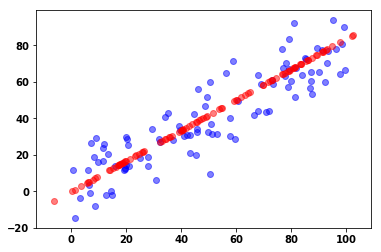

In [43]:
plt.scatter(X[:,0], X[:,1], color='b', alpha=0.5)
plt.scatter(X_restore[:,0], X_restore[:,1], color='r', alpha=0.5)
plt.show()

scikit-learn中的PCA跟上面的使用方法一样。

## 04 scikit-learn 中的PCA

In [44]:
from sklearn.decomposition import PCA

In [45]:
pca = PCA(n_components=1)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [46]:
pca.components_

array([[-0.76714796, -0.64147019]])

In [47]:
X_reduction = pca.transform(X)
X_restore = pca.inverse_transform(X_reduction)

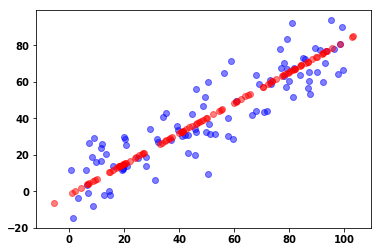

In [48]:
plt.scatter(X[:,0], X[:,1], color='b', alpha=0.5)
plt.scatter(X_restore[:,0], X_restore[:,1], color='r', alpha=0.5)
plt.show()

## 05 实战

使用datasets中的手写识别数据集。首先使用knn算法跑结果看看:

In [49]:
from sklearn import datasets

In [50]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [53]:
X_train.shape

(1347, 64)

In [54]:
from sklearn.neighbors import KNeighborsClassifier

In [55]:
%%time

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

CPU times: user 4.83 ms, sys: 1.82 ms, total: 6.66 ms
Wall time: 6.3 ms


平均精度的结果为:

In [56]:
knn_clf.score(X_test, y_test)

0.9866666666666667

### 使用PCA对数据进行降维

In [57]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

In [59]:
%%time 

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)

CPU times: user 1.62 ms, sys: 410 µs, total: 2.03 ms
Wall time: 2.11 ms


最后再进行打分，得分为:

In [60]:
knn_clf.score(X_test_reduction, y_test)

0.6066666666666667

可以发现，经过降维后，因为维度就剩下2个，得出的分值很低，为了提高分值，应该保留更多的特征值。但是具体保留多少特征合适?有什么衡量指标可以作为参考?

### 主成分所解释的方差

sklearn-PCA中有个变量为pca.explained_variance_ratio_，可以用来衡量映射后的数据保留了原始数据的多少信息 (方差)。对于上面求得的结果，有如下的值:

In [61]:
pca.explained_variance_ratio_

array([0.14566817, 0.13735469])

这表示:经过映射后的数据，只保留原始数据大约百分之(14+13=27)的方差，丢掉了原来约73的方差，这个损失是比较大的，所以得出来的分数很低。

现在的问题是，应该保留多少的维度使得信息丢失在允许法范围内。假设选取的主成分的个数和原始样本特征维度一 样，由于explained_variance_ratio explained_variance_ratio发现，越到后面，值越小，甚至几乎可以忽略。

In [62]:
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
pca.explained_variance_ratio_

array([1.45668166e-01, 1.37354688e-01, 1.17777287e-01, 8.49968861e-02,
       5.86018996e-02, 5.11542945e-02, 4.26605279e-02, 3.60119663e-02,
       3.41105814e-02, 3.05407804e-02, 2.42337671e-02, 2.28700570e-02,
       1.80304649e-02, 1.79346003e-02, 1.45798298e-02, 1.42044841e-02,
       1.29961033e-02, 1.26617002e-02, 1.01728635e-02, 9.09314698e-03,
       8.85220461e-03, 7.73828332e-03, 7.60516219e-03, 7.11864860e-03,
       6.85977267e-03, 5.76411920e-03, 5.71688020e-03, 5.08255707e-03,
       4.89020776e-03, 4.34888085e-03, 3.72917505e-03, 3.57755036e-03,
       3.26989470e-03, 3.14917937e-03, 3.09269839e-03, 2.87619649e-03,
       2.50362666e-03, 2.25417403e-03, 2.20030857e-03, 1.98028746e-03,
       1.88195578e-03, 1.52769283e-03, 1.42823692e-03, 1.38003340e-03,
       1.17572392e-03, 1.07377463e-03, 9.55152460e-04, 9.00017642e-04,
       5.79162563e-04, 3.82793717e-04, 2.38328586e-04, 8.40132221e-05,
       5.60545588e-05, 5.48538930e-05, 1.08077650e-05, 4.01354717e-06,
      

现在将这些值从前往后依次进行累加，并在坐标轴上展现。

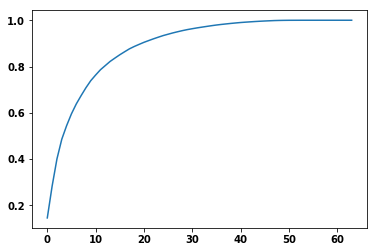

In [63]:
plt.plot([i for i in range(X_train.shape[1])], 
         [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(X_train.shape[1])])

plt.show()

观察该图可以发现，当横轴为0时，纵轴也为0(丢失了所有信息)，当横轴为特征值大小时，纵轴为1(保留了全部信息)。因此，比如想要保留95%的信息，就可以通过该图知道应该保留多少个特征维度。

In [64]:
pca = PCA(0.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [65]:
pca.n_components_

28

In [66]:
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

In [67]:
%%time

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)

CPU times: user 2.56 ms, sys: 964 µs, total: 3.53 ms
Wall time: 3.9 ms


In [68]:
knn_clf.score(X_test_reduction, y_test)

0.98

值明显得到了提高。而且如果进行时间测试，会发现时间缩短了很多。这就是pca的作用。

### 使用PCA对数据进行降维可视化

In [69]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduction = pca.transform(X)

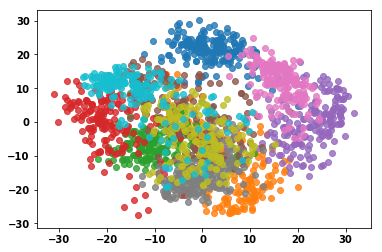

In [70]:
for i in range(10):
    plt.scatter(X_reduction[y==i,0], X_reduction[y==i,1], alpha=0.8)
    
plt.show()